# Adiabatic Evolution
## Background

In this example, we will show how to use Bloqade to prepare ordered ground states in the Rydberg system.
The example is based on the experimental works in a [1D system](https://www.nature.com/articles/nature24622) and [2D system](https://www.nature.com/articles/s41586-021-03582-4).
The Rydberg Hamiltonian can be found in the Bloqade page.

Due to the strong Rydberg interactions, only one Rydberg excitation is allowed within the blockade radius (see Rydberg Blockade). With a positive detuning Δ, more Rydberg excitations
are favored (to lower the ground state(s) energy). The interplay of these two mechanisms allows the creation of different ordered states depending on the strength of the blockade radius and the detunings,
such as the [$Z_N$ ordered states](https://www.nature.com/articles/nature24622) in 1D and the checkerboard phase, the star phase, and a pure quantum phase (the striated phase) in 2D
(see the [experimental](https://www.nature.com/articles/s41586-021-03582-4) and [theory](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.103601) papers).

Here, we use the Quantum Adiabatic Algorithm (QAA) to prepare these quantum many-body ground states. To do that, we can start with all atoms in the ground state
$| 0 \rangle$, which is the ground state of the many-body Hamiltonian with a large negative detuning $\Delta$.
Then, the Rabi frequency $\Omega$ is turned on, and the detuning strength is ramped up from a large negative value to postive values. If this process is slow enough, the quantum state of the system stays close to the ground state of the
instantaneous Hamiltonian. At the end of this process, we arrive at a target Hamiltonian, and correspondingly, the prepared state is approximately the ground state for the final Hamiltonian.
A quantum phase transition typically occurs during this process and one can probe the phase transition and critical phenomena by simulating and understanding the quantum dynamics.

Let's start by importing the required libraries:

In [26]:
using Pkg; Pkg.instantiate()

In [27]:
using Bloqade
using PythonCall
using KrylovKit
using SparseArrays

plt = pyimport("matplotlib.pyplot");

# Ground State Properties

We start by probing the ground state properties of the Rydberg Hamiltonian in a 1D system.
Let's use the 1D chain for simplicity and vary the parameters of the Rydberg Hamiltonian and calculate the corresponding ground state properties.
Here, we consider a chain with 9 atoms, where nearby atoms are seperated by a distance of 5.72 μm.
Please refer to the Rydberg Blockade page on tips for setting the separation distance for the atoms in preparing different ordered states.
One can generate the system as follows using the function `generate_sites`:

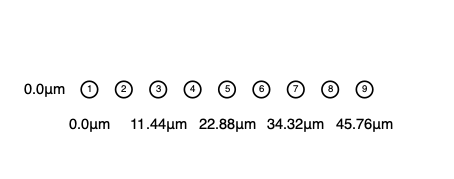

In [28]:
nsites = 9
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72)

We fix the Rabi frequency to be $Ω = 2π * 4$ MHz, and study the ground state as a function of the detuning $Δ$:

In [33]:
Ω = 2π * 4
Δ_step = 30
Δ = LinRange(-2π * 10, 2π * 10, Δ_step);

The Rydberg density profile can be computed for each parameter of $\Delta$ as:

In [34]:
density_g = zeros(Δ_step, nsites)

for ii in 1:Δ_step
    h_ii = rydberg_h(atoms; Δ = Δ[ii], Ω) # create the Rydberg Hamiltonian
    h_m = mat(h_ii) # convert the Hamiltonian into a matrix
    vals, vecs, info = KrylovKit.eigsolve(h_m, 1, :SR) # find the ground state eigenvalue and eigenvector
    g_state = ArrayReg(vecs[1]) # creates the initial state with all atoms in $| 0 \rangle$ state

    for jj in 1:nsites
        density_g[ii, jj] = rydberg_density(g_state, jj) # measure the density of Rydberg excitations on each site
    end
end

To compare, we first plot the density profile when $\Delta= -2π * 10$ MHz:

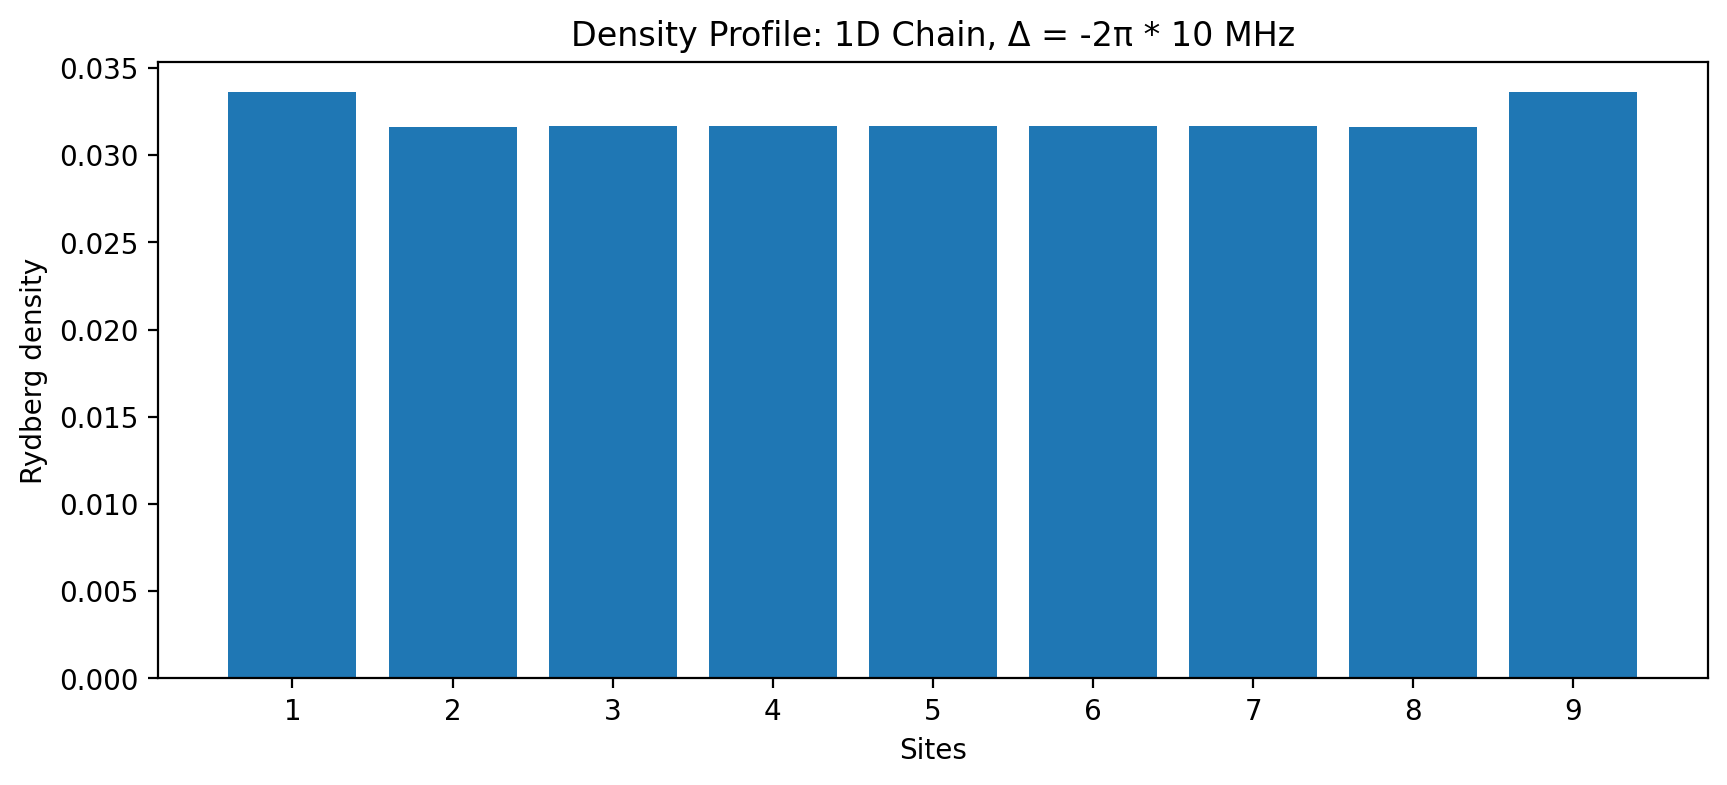

In [35]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(1:nsites, density_g[1, :])
ax.set_xticks(1:nsites)
ax.set_xlabel("Sites")
ax.set_ylabel("Rydberg density")
ax.set_title("Density Profile: 1D Chain, Δ = -2π * 10 MHz")
fig

We can see that the Rydberg densities in this case is close to 0 for all sites. In contrast, for $\Delta= 2π * 10$ MHz, the density shows a clear $Z_2$ ordered profile:

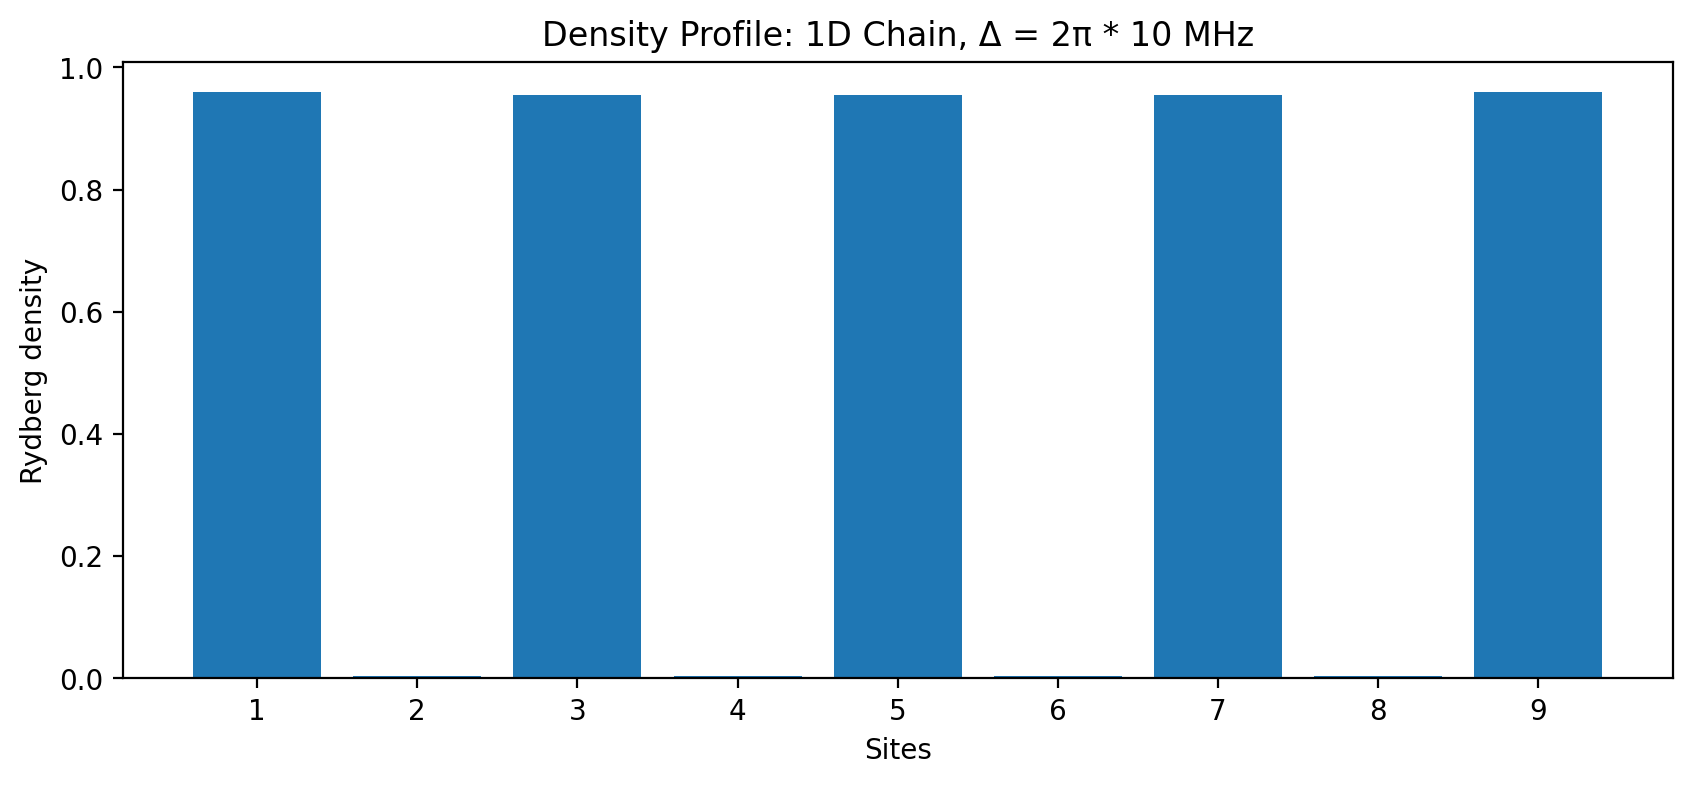

In [36]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(1:nsites, density_g[30, :])
ax.set_xticks(1:nsites)
ax.set_xlabel("Sites")
ax.set_ylabel("Rydberg density")
ax.set_title("Density Profile: 1D Chain, Δ = 2π * 10 MHz")
fig

More generally, we can plot an order parameter as a function of $\Delta$ to clearly see the onset of phase transition.
The order parameter can be defined as the difference of Rydberg densities on even and odd sites.

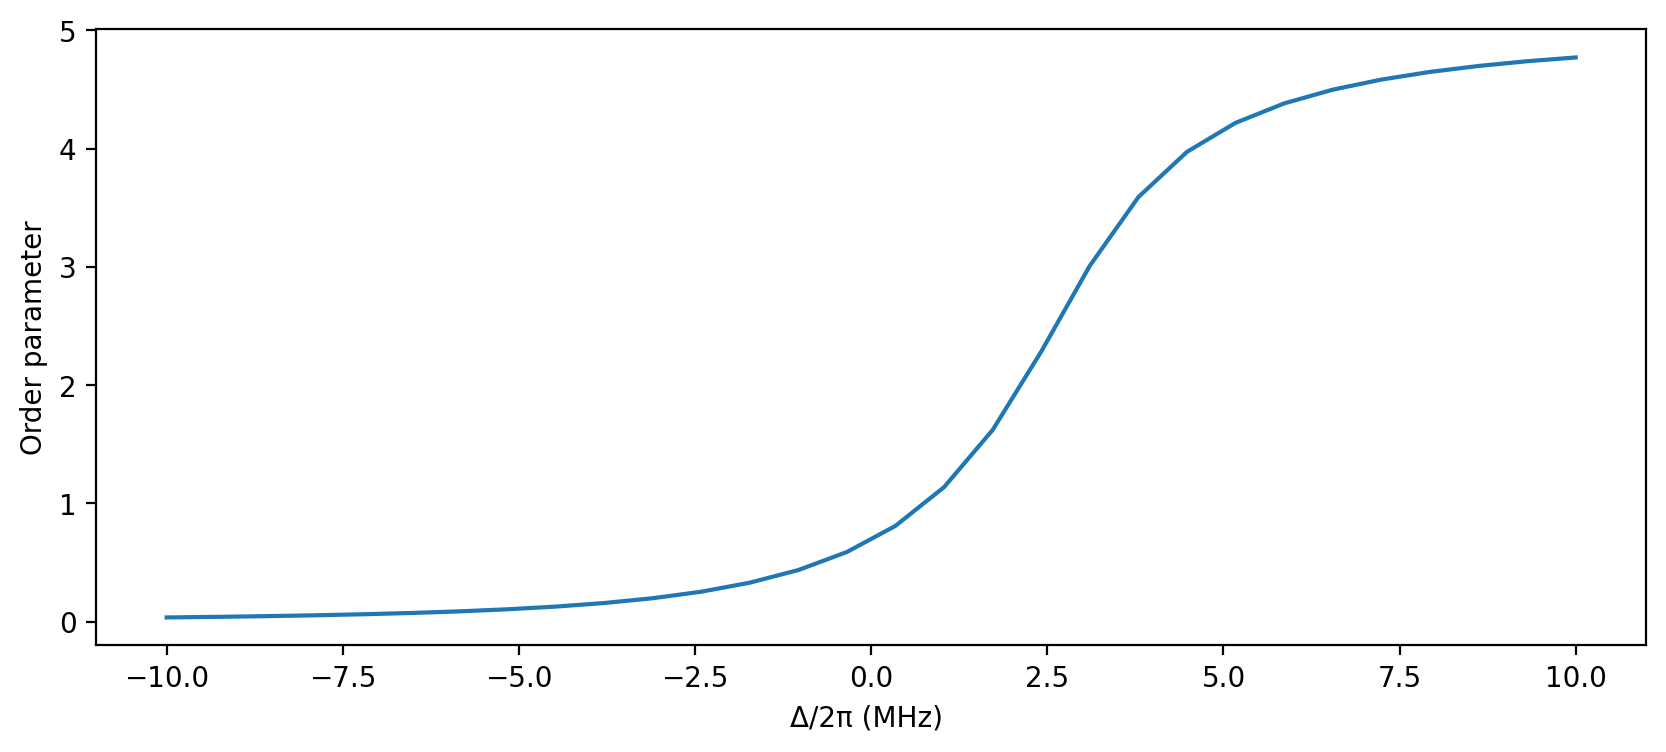

In [37]:
order_para = map(1:Δ_step) do ii
    return sum(density_g[ii, 1:2:nsites]) - sum(density_g[ii, 2:2:nsites])
end

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(Δ / 2π, order_para)
ax.set_xlabel("Δ/2π (MHz) ")
ax.set_ylabel("Order parameter")
fig

From the density profile of ground states and the change in the order parameter, we can observe a phase transition with changing $\Delta$.
Below, we show that by slowly changing the parameters of the Hamiltonian, we can follow the trajectory of the ground states and adiabatically evolve the atoms from the ground state to the $Z_2$
ordered state.

# Preparation of Ordered States in 1D

We first specify the adiabatic pulse sequence for Rabi frequency by using the built-in waveform function `piecewise_linear`:

In [38]:
total_time = 3.0;
Ω_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, total_time], values = [0.0, Ω_max, Ω_max, 0, 0]);

The detuning sequence can also be created in a similar way:

In [39]:
U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, total_time], values = [U1, U1, U2, U2]);

We plot the two waveforms:

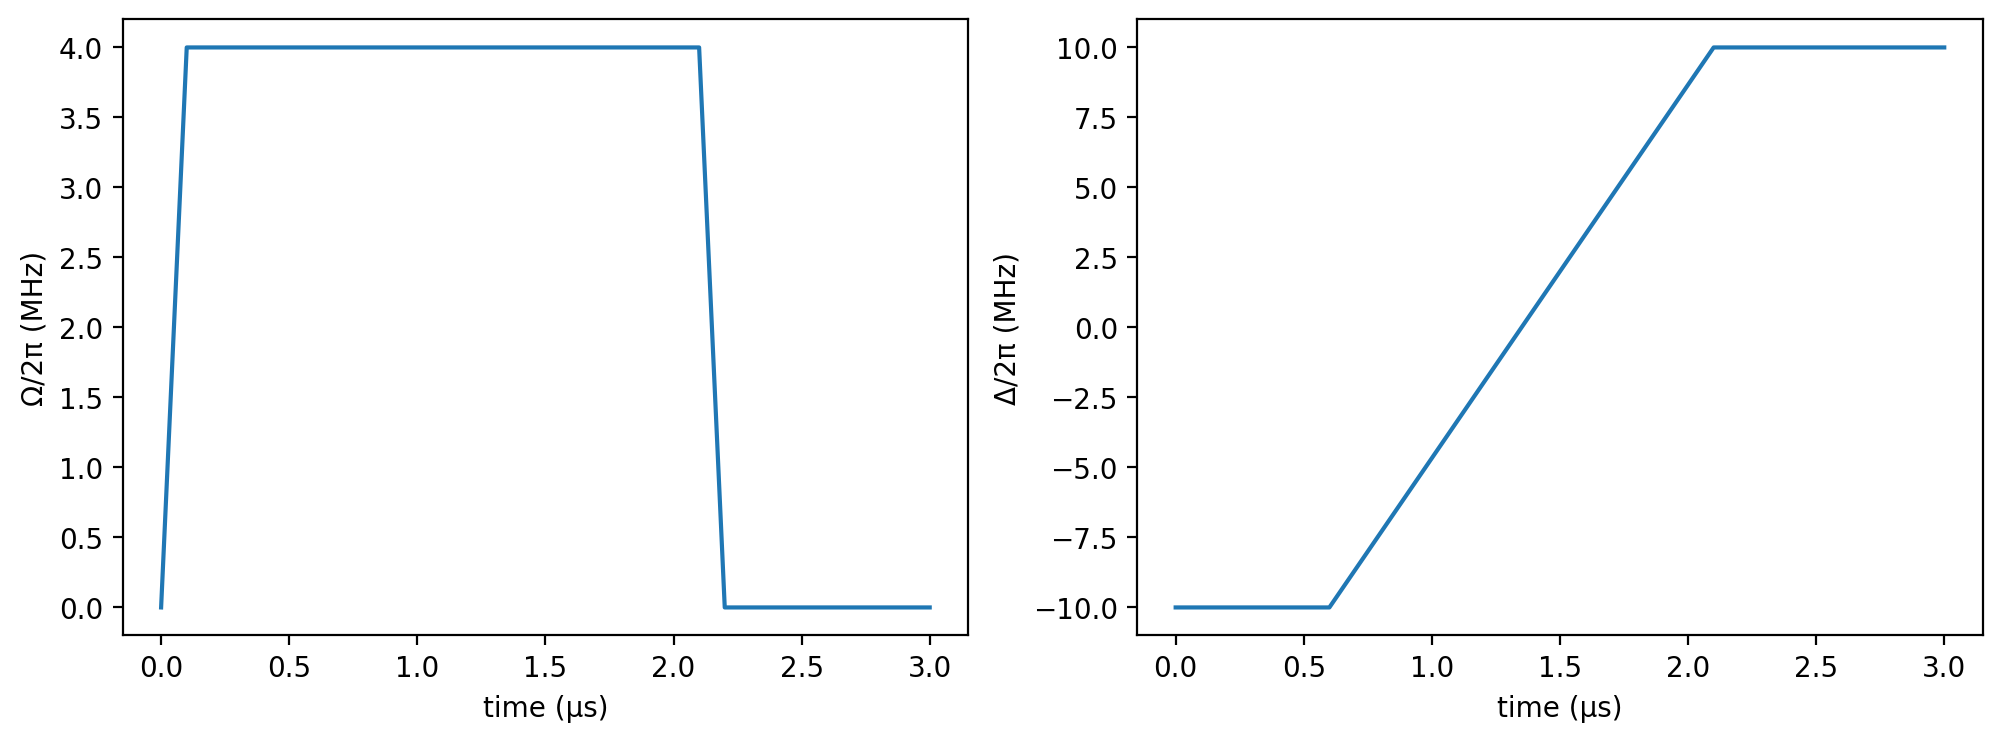

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

We generate the positions of a 1D atomic chain again:

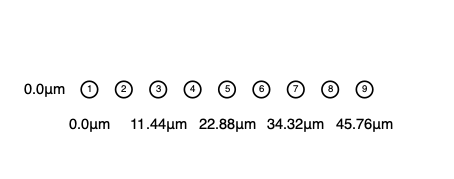

In [41]:
nsites = 9
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72)

Note that we have specified the nearest-neighbor atoms to be seperated by 5.72 μm in order to prepare a $Z_2$ ordered state.
With the waveforms and atomic coordinates specified, the time-dependent Hamiltonian can be simply generated by:

In [44]:
h = rydberg_h(atoms; Δ, Ω)

nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


We then specify all atoms to be in the ground state initially, and set up the emulation problem by choosing an ODE solver:

In [45]:
reg = zero_state(9);
prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());

The default for the integrator is to use adaptive steps. One can use `TimeChoiceIterator` to specify the time points one would like to measure some observables.
Here, we measure the Rydberg density on each site:

In [46]:
densities = []
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...);

and finally plot the time-dependent dynamics of Rydberg density for each site:

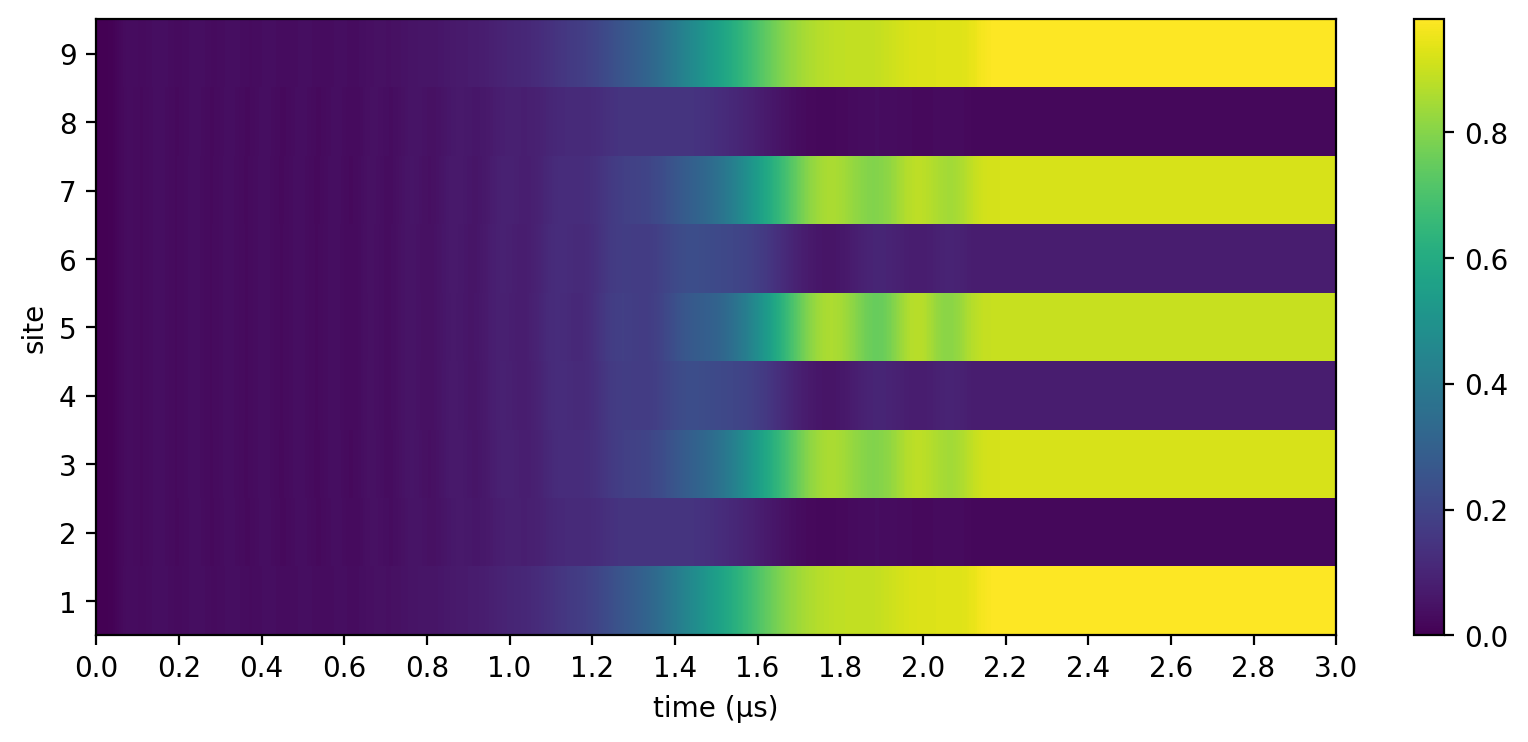

In [47]:
fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

We can clearly see that a $Z_2$ ordered state has been generated by the specified adiabatic pulse sequence.
We can also confirm it by plotting the bitstring distribution at the final time step:

In [ ]:
bitstring_hist(reg; nlargest = 20)

To prepare the $Z_3$ or $Z_4$ states, we can reduce the separation between nearby atoms to 3.57 μm or 2.87 μm respectively.
Please refer to the Rydberg Blockade page on how to set the separation distance for preparing the ordered states.

# Emulation in the Blockade Subspace

In the above example, we have run the fullspace emulation, without truncating the Hilbert space.
To speed up the emulation, we can also run it in the blockade subspace, throwing out the configurations of the Hilbert space that violate the blockade constraint.
See subspace for more details.
This can be done by changing the register to a RydbergReg by feeding a subspace object.

The subspace can be found by looking up the independent sets of the graph constructed by a subspace radius; here we choose the subspace radius to be 5.73 μm:

In [48]:
space = blockade_subspace(atoms, 5.73);

Then create our register in the subspace:

In [49]:
reg = zero_state(space)

SubspaceArrayReg{Vector{ComplexF64}, Subspace{Vector{Int64}}}(9, ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], Subspace{Vector{Int64}}(9, Dict(5 => 5, 265 => 62, 325 => 81, 32 => 14, 136 => 40, 145 => 44, 73 => 28, 272 => 64, 164 => 51, 320 => 77…), [0, 1, 2, 4, 5, 8, 9, 10, 16, 17  …  324, 325, 328, 329, 330, 336, 337, 338, 340, 341]))

The rest of codes will be the same as the fullspace:

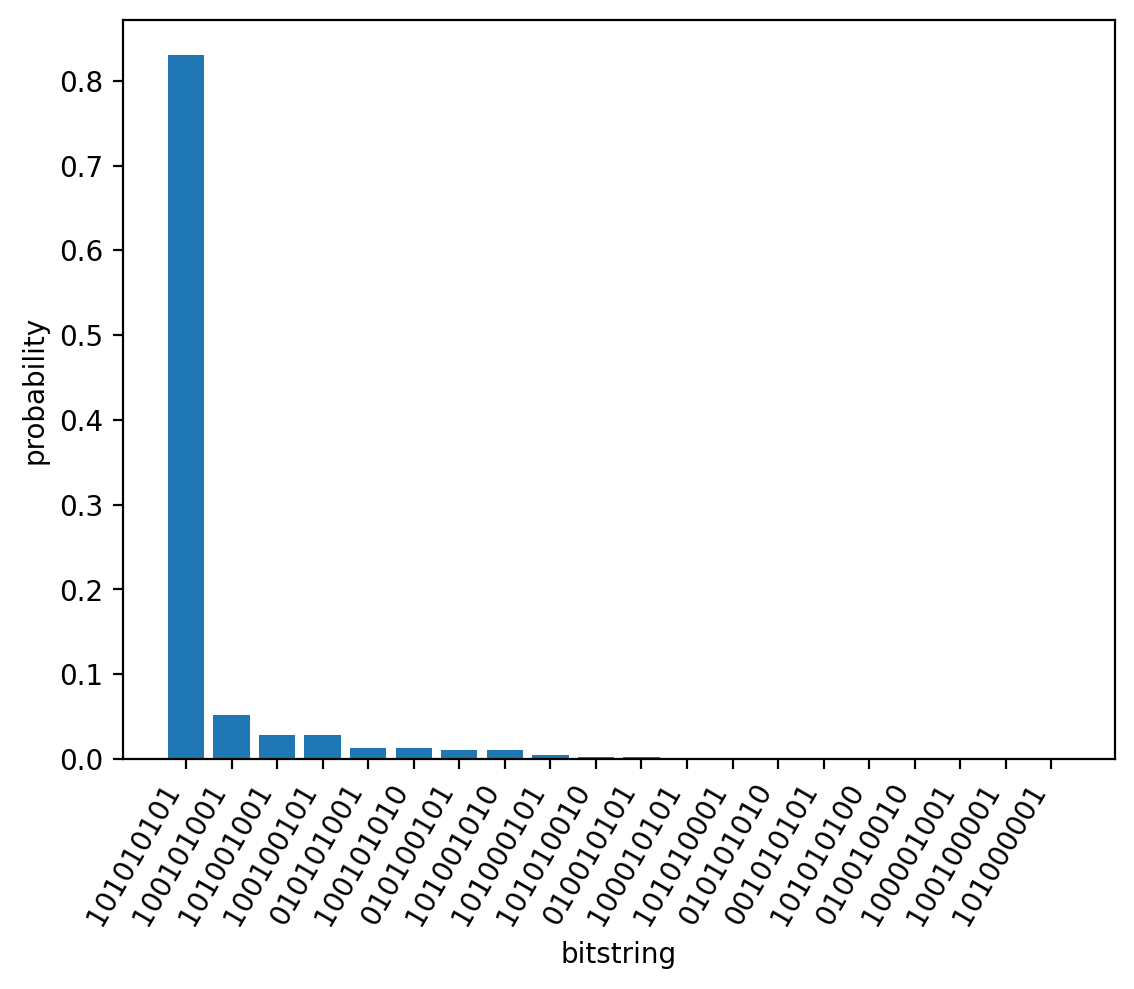

In [50]:
prob = SchrodingerProblem(reg, total_time, h)
emulate!(prob)
bitstring_hist(prob.reg; nlargest = 20)

In [ ]:
using CUDA
dprob = adpat(CuArray{Float32}, prob)
emulate!(dprob)

# State Preparation in 2D

Now we show how to prepare a 2D checkerboard phase. Most of codes will be the same as the 1D case, except that we will choose slightly different
parameters and specify a square lattice instead of a chain:

In [ ]:
nx, ny = 3, 3
nsites = nx * ny
atoms = generate_sites(SquareLattice(), nx, ny, scale = 6.7)

We program and plot the waveforms in the following:

In [ ]:
total_time = 2.9
Ω_max = 2π * 4.3
Ω = piecewise_linear(clocks = [0.0, 0.3, 2.6, total_time], values = [0.0, Ω_max, Ω_max, 0]);

U = 2π * 15.0
Δ = piecewise_linear(clocks = [0.0, 0.3, 2.6, total_time], values = [-U, -U, U, U]);

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Then, we use the above waveforms and atom sites to create a Hamiltonian and define a time evolution problem:

In [ ]:
h = rydberg_h(atoms; Δ, Ω)
reg = zero_state(9);
prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());

Again, we can use `TimeChoiceIterator` to specify the time points for measuring some observables:

In [ ]:
densities = [];
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...)

fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*